## Marketing Channel Attribution Example Using Markov Chains

### Markov Chains describe a sequence of possible events in which the probability of each event depends only on the state attained in the previous event. In the context of channel attribution, Markov Chains give us a framework to model user journeys and how each channel factors into the users traveling from one channel to another to eventually purchase (or not).

### The underlying concept of Markov chains is that customer journey data can be processed  to identify the probabilities of moving from one event to another in a network of potential marketing channel events and conversion events.

Performed by:

Ken Wood

Marketing Data Scientist

SugarCRM

kwood@sugarcrm.com

(919) 802-0065



### Mount the Google Drive where the data files are located.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Load the necessary Python software packages to perform the attribution analysis...

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import subprocess
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)

sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Load the 'Channel_attribution.csv' file from location *''/content/drive/My Drive/Colab Notebooks/Marketing Attribution - Markov Chains/'* and develop some summary statistics.



In [3]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Marketing Channel Attribution - Markov Chains/Channel_attribution.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 21 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   R05A.01  2392 non-null   int64  
 1   R05A.02  2392 non-null   int64  
 2   R05A.03  2384 non-null   float64
 3   R05A.04  2217 non-null   float64
 4   R05A.05  1586 non-null   float64
 5   R05A.06  1030 non-null   float64
 6   R05A.07  605 non-null    float64
 7   R05A.08  391 non-null    float64
 8   R05A.09  228 non-null    float64
 9   R05A.10  138 non-null    float64
 10  R05A.11  82 non-null     float64
 11  R05A.12  52 non-null     float64
 12  R05A.13  29 non-null     float64
 13  R05A.14  19 non-null     float64
 14  R05A.15  8 non-null      float64
 15  R05A.16  7 non-null      float64
 16  R05A.17  4 non-null      float64
 17  R05A.18  2 non-null      float64
 18  R05A.19  1 non-null      float64
 19  R05A.20  1 non-null      float64
 20  Output   0 non-null      float64
dtypes: float64(19)

### Let's examine 'Channel_attribution.csv'...

In [4]:
print("Shape of dataframe: ",df.shape,"\n")             # Get shape of dataframe.
print(df.head())                                        # Print first 5 rows of dataframe.
print(df.describe())                                    # Get some summary stats on the dataframe variables

Shape of dataframe:  (2392, 21) 

   R05A.01  R05A.02  R05A.03  R05A.04  ...  R05A.18  R05A.19  R05A.20  Output
0       16        4      3.0      5.0  ...      NaN      NaN      NaN     NaN
1        2        1      9.0     10.0  ...      NaN      NaN      NaN     NaN
2        9       13     20.0     16.0  ...      NaN      NaN      NaN     NaN
3        8       15     20.0     21.0  ...      NaN      NaN      NaN     NaN
4       16        9     13.0     20.0  ...      NaN      NaN      NaN     NaN

[5 rows x 21 columns]
           R05A.01      R05A.02      R05A.03  ...  R05A.19  R05A.20  Output
count  2392.000000  2392.000000  2384.000000  ...      1.0      1.0     0.0
mean      8.391722     9.291388    12.304530  ...     20.0     21.0     NaN
std       4.462116     5.375250     6.524588  ...      NaN      NaN     NaN
min       1.000000     1.000000     1.000000  ...     20.0     21.0     NaN
25%       4.000000     4.000000     6.000000  ...     20.0     21.0     NaN
50%      10.000000 

### Get a list of columns in df and convert all variables to type 'str'. Also, remove any trailing '.0'

In [5]:
cols = df.columns  

for col in cols:
  df[col] = df[col].astype(str)
  df[col] = df[col].map(lambda x: str(x)[:-2] if '.' in x else str(x))

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 21 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   R05A.01  2392 non-null   object
 1   R05A.02  2392 non-null   object
 2   R05A.03  2392 non-null   object
 3   R05A.04  2392 non-null   object
 4   R05A.05  2392 non-null   object
 5   R05A.06  2392 non-null   object
 6   R05A.07  2392 non-null   object
 7   R05A.08  2392 non-null   object
 8   R05A.09  2392 non-null   object
 9   R05A.10  2392 non-null   object
 10  R05A.11  2392 non-null   object
 11  R05A.12  2392 non-null   object
 12  R05A.13  2392 non-null   object
 13  R05A.14  2392 non-null   object
 14  R05A.15  2392 non-null   object
 15  R05A.16  2392 non-null   object
 16  R05A.17  2392 non-null   object
 17  R05A.18  2392 non-null   object
 18  R05A.19  2392 non-null   object
 19  R05A.20  2392 non-null   object
 20  Output   2392 non-null   object
dtypes: object(21)
memory usage: 392.6+ KB

### We now create the Markov chain framework where user journeys are combined into a single variable of the form 'Channel 1 > Channel 2 > Channel 3 > ...' 

In [7]:
df['Path'] = ''  # First we create the 'Path' variable.

for i in df.index:
    #df.at[i, 'Path'] = 'Start'
    for x in cols:
        df.at[i, 'Path'] = df.at[i, 'Path'] + df.at[i, x] + ' > '  # df.at[x,y] accesses the element in the 'x'th row and 'y'th column

In [8]:
df['Path'].head()

0    16 > 4 > 3 > 5 > 10 > 8 > 6 > 8 > 13 > 20 > 21...
1    2 > 1 > 9 > 10 > 1 > 4 > 3 > 21 > nan > nan > ...
2    9 > 13 > 20 > 16 > 15 > 21 > nan > nan > nan >...
3    8 > 15 > 20 > 21 > nan > nan > nan > nan > nan...
4    16 > 9 > 13 > 20 > 21 > nan > nan > nan > nan ...
Name: Path, dtype: object

### Since Channel 21 in our dataset is a conversion event, we will separate that channel from the path and create a separate conversion variable holding the number of conversions happening (still only 1 in our user journey level data)




In [9]:
# Split path on conversion (channel 21)
df['Path'] = df['Path'].map(lambda x: x.split(' > 21')[0])

# Create conversion value we can sum to get total conversions for each path
df['Conversion'] = 1

In [10]:
df.head()

,R05A.01,R05A.02,R05A.03,R05A.04,R05A.05,R05A.06,R05A.07,R05A.08,R05A.09,R05A.10,R05A.11,R05A.12,R05A.13,R05A.14,R05A.15,R05A.16,R05A.17,R05A.18,R05A.19,R05A.20,Output,Path,Conversion
0,16,4,3,5,10,8,6,8,13,20,21,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,16 > 4 > 3 > 5 > 10 > 8 > 6 > 8 > 13 > 20,1
1,2,1,9,10,1,4,3,21,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2 > 1 > 9 > 10 > 1 > 4 > 3,1
2,9,13,20,16,15,21,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,9 > 13 > 20 > 16 > 15,1
3,8,15,20,21,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,8 > 15 > 20,1
4,16,9,13,20,21,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,16 > 9 > 13 > 20,1


### We’re now almost done with the initial data manipulation work. Our data still contains all the original columns, so we select the subset of columns that we need going forward. Since some users may have taken the same journey, we will group our data by unique user journeys and our conversion variable will hold the number of conversions for each respective journey.

In [11]:
# Select relevant columns
df = df[['Path', 'Conversion']]

# Sum conversions by Path
df = df.groupby('Path').sum().reset_index()

# Write DF to CSV to be executed in R
df.to_csv('/content/drive/My Drive/Colab Notebooks/Marketing Channel Attribution - Markov Chains/Paths.csv', index=False)

### The last line in the above piece of code will output our data to a .csv file now that we’re done with the data manipulations. It might be handy to have this data available for transparency purposes, and, in our case, we will also use this .csv file to run the Markov chain attribution approach.

### *   We will leverage the ChannelAttribution R library which has the theory behind Markov chains built into a single application.
### *   We will run the R script below in R Studio and then return to Python to process the output files provided by the attribution analysis.



### Load the Channel Attribution Package in R

if(!require(ChannelAttribution)){
  install.packages("ChannelAttribution")
  library(ChannelAttribution)
}

### Set Working Directory
setwd <- setwd('/content/drive/My Drive/Colab Notebooks/Marketing Attribution - Markov Chains')

### Read in our CSV file outputed by the Python script
df <- read.csv('Paths.csv')

### Select only the necessary columns
df <- df[c(1,2)]

### Run the Markov Model function
M <- markov_model(df, 'Path', var_value = 'Conversion', var_conv = 'Conversion', sep = '>', order=1, out_more = TRUE)

### Export the Markov model output to a csv file, to be read back into Python
write.csv(M$result, file = "Markov - Output - Conversion values.csv", row.names=FALSE)

### Output the transition matrix as well, for visualization purposes
write.csv(M$transition_matrix, file = "Markov - Output - Transition matrix.csv", row.names=FALSE)

In [12]:
# Load in the CSV file with the model output from R
markov = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Marketing Channel Attribution - Markov Chains/Markov - Output - Conversion values.csv')

# Select only the necessary columns and rename them
markov = markov[['channel_name','total_conversions']]
markov.columns = ['Channel', 'Conversion']
markov['Attribution'] = "Markov Chain"
markov = markov[['Channel','Attribution','Conversion']]
markov.head()

,Channel,Attribution,Conversion
0,1,Markov Chain,82.805970
1,20,Markov Chain,439.582090
2,12,Markov Chain,81.253731
3,14,Markov Chain,64.238806
4,13,Markov Chain,197.791045


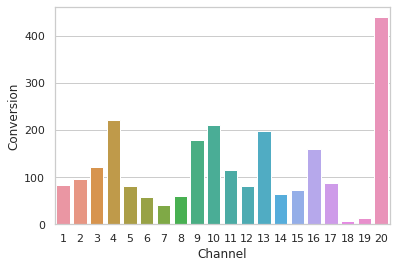

In [13]:
ax = sns.barplot(x="Channel", y="Conversion", data=markov)

### Let's calculate conversion contribution numbers for First Touch attribution.

In [14]:
# First Touch Attribution
df['First Touch'] = df['Path'].map(lambda x: x.split(' > ')[0])  # Get first channel in path and remove '>'
df_ft = pd.DataFrame()
df_ft['Channel'] = df['First Touch']
df_ft['Attribution'] = 'First Touch'
df_ft['Conversion'] = 1
df_ft = df_ft.groupby(['Channel', 'Attribution']).sum().reset_index()
df_ft.head()

,Channel,Attribution,Conversion
0,1,First Touch,116
1,10,First Touch,440
2,11,First Touch,50
3,12,First Touch,64
4,13,First Touch,245


### Let's calculate conversion contribution numbers for Last Touch attribution.

In [15]:
# Last Touch Attribution
df['Last Touch'] = df['Path'].map(lambda x: x.split(' > ')[-1])  # Get last channel in path and remove preceding '>'
df_lt = pd.DataFrame()
df_lt['Channel'] = df['Last Touch']
df_lt['Attribution'] = 'Last Touch'
df_lt['Conversion'] = 1
df_lt = df_lt.groupby(['Channel', 'Attribution']).sum().reset_index()
df_lt.head()

,Channel,Attribution,Conversion
0,1,Last Touch,17
1,10,Last Touch,38
2,11,Last Touch,33
3,12,Last Touch,23
4,13,Last Touch,71


### Let's calculate conversion contribution numbers for Linear attribution.

In [16]:
# Linear Attribution
channel = []
conversion = []
for i in df.index:
    for j in df.at[i, 'Path'].split(' > '):   # remove the '>' between each channel to get length of journey (a list)
        # print(df.at[i, 'Path'].split(' > '))
        channel.append(j)
        conversion.append(1/len(df.at[i, 'Path'].split(' > ')))  # each channel gets assigned conversion = 1/(length of journey)
lin_att_df = pd.DataFrame()
lin_att_df['Channel'] = channel
lin_att_df['Attribution'] = 'Linear'
lin_att_df['Conversion'] = conversion
lin_att_df = lin_att_df.groupby(['Channel', 'Attribution']).sum().reset_index()
lin_att_df.head()

,Channel,Attribution,Conversion
0,1,Linear,66.873661
1,10,Linear,168.222393
2,11,Linear,88.625714
3,12,Linear,67.961197
4,13,Linear,161.356219


### Let’s merge all our 4 approaches together and evaluate the differences in outputs.

In [17]:
# Concatenate the four data frames to a single data frame
df_total_attr = pd.concat([df_ft, df_lt, lin_att_df, markov],sort=False)
df_total_attr['Channel'] = df_total_attr['Channel'].astype(int)
df_total_attr.sort_values(by='Channel', ascending=True,inplace=True)
df_total_attr.head()

,Channel,Attribution,Conversion
0,1,First Touch,116.000000
0,1,Markov Chain,82.805970
0,1,Last Touch,17.000000
0,1,Linear,66.873661
11,2,Linear,79.945001


### Let's visualize the attributions...

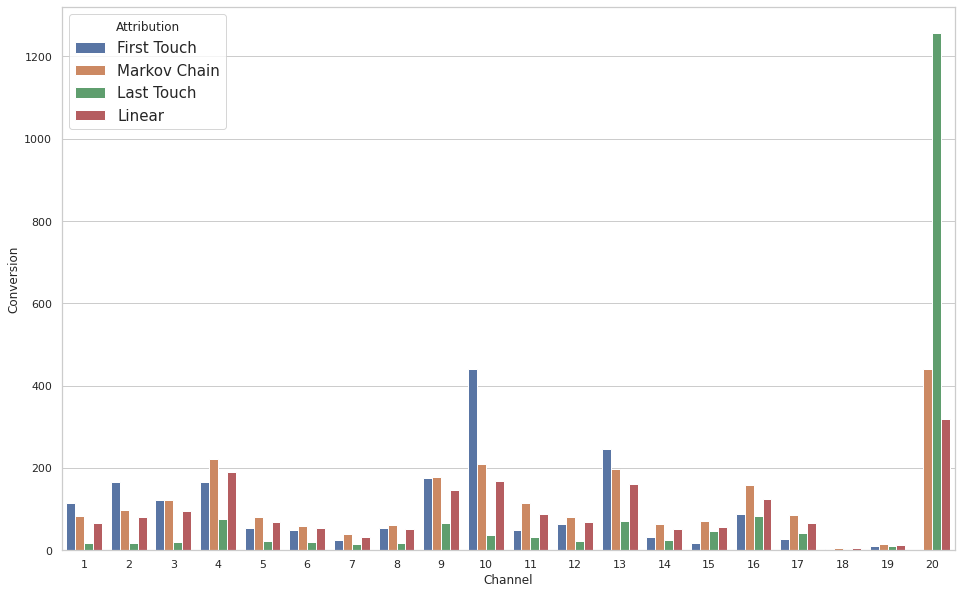

In [18]:
# Visualize the attributions
sns.set_style("whitegrid")
plt.rc('legend', fontsize=15)
fig, ax = plt.subplots(figsize=(16, 10))
sns.barplot(x='Channel', y='Conversion', hue='Attribution', data=df_total_attr)
plt.show()

### Looking at the above chart, we can quickly conclude that most user journeys start with Channel 10 and end with Channel 20, while no user journeys start at Channel 20.

In [19]:
# Read in transition matrix CSV
trans_prob = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Marketing Channel Attribution - Markov Chains/Markov - Output - Transition matrix.csv')
trans_prob.info()
trans_prob.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   channel_from            393 non-null    object 
 1   channel_to              393 non-null    object 
 2   transition_probability  393 non-null    float64
dtypes: float64(1), object(2)
memory usage: 9.3+ KB


,channel_from,channel_to,transition_probability
388,20,1,0.046875
389,20,14,0.062500
390,20,7,0.015625
391,20,13,0.015625
392,20,4,0.015625


In [20]:
# Convert data to floats
trans_prob ['transition_probability'] = trans_prob ['transition_probability'].astype(float)

# Convert start and conversion event to numeric values so we can sort and iterate through
trans_prob.replace('(start)', '0', inplace=True)
trans_prob.replace('(conversion)', '21', inplace=True)
trans_prob.head()

,channel_from,channel_to,transition_probability
0,0,1,0.054348
1,0,10,0.228679
2,0,11,0.027592
3,0,3,0.031355
4,0,5,0.133779


In [21]:
# Get unique origin channels
channel_from_unique = trans_prob['channel_from'].unique().tolist()
channel_from_unique.sort(key=float)

# Get unique destination channels
channel_to_unique = trans_prob['channel_to'].unique().tolist()
channel_to_unique.sort(key=float)

print(channel_to_unique,channel_from_unique)

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21'] ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']


### Create the transition matrix...

In [22]:
trans_matrix = pd.DataFrame(columns=channel_to_unique, index=channel_from_unique)

### Assign the probabilities to the corresponding cells in our transition matrix

In [23]:
for f in channel_from_unique:
    for t in channel_to_unique:

        # get row for each unique 'to' and 'from' channel combination and set the row = x
        x = trans_prob [(trans_prob ['channel_from'] == f) & (trans_prob ['channel_to'] == t)]
        prob = x['transition_probability'].values  # pull transition probability value from x
       
        if prob.size > 0:
            trans_matrix[t][f] = prob[0]
        else:
            trans_matrix[t][f] = 0

In [24]:
trans_matrix

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,0.0543478,0,0.0313545,0.014214,0.133779,0.0702341,0.0129599,0.020903,0.0234114,0.228679,0.027592,0.0464047,0.083194,0.0965719,0.0108696,0.0259197,0.104515,0.00919732,0.00167224,0.0041806,0
1,0,0.142857,0.0384615,0.0137363,0.043956,0.101648,0.0137363,0.043956,0.0549451,0.0521978,0.021978,0.043956,0.134615,0.123626,0.0137363,0.0247253,0.0576923,0.0137363,0.00274725,0.00824176,0.0494505
2,0.00622407,0,0.00622407,0.00518672,0.0093361,0.00518672,0.0119295,0.00466805,0.00155602,0.00829876,0.00414938,0.0176349,0.00363071,0.0103734,0.00155602,0.00259336,0.0093361,0.00778008,0.00155602,0.000518672,0.882261
3,0.0188172,0.198925,0,0.0591398,0.177419,0.0241935,0.0510753,0.00268817,0.016129,0.0510753,0.0537634,0.0483871,0.0403226,0.094086,0.00806452,0.0215054,0.0188172,0.0295699,0.00268817,0.0215054,0.061828
4,0.0109489,0.321168,0.0255474,0,0.0656934,0.0182482,0.0328467,0.0255474,0.0218978,0.0218978,0.0145985,0.109489,0.00729927,0.0729927,0.0145985,0.0364964,0.0510949,0.0437956,0.0109489,0.00364964,0.0912409
5,0.0127389,0.219745,0.0530786,0.0530786,0,0.0318471,0.0276008,0.00849257,0.0191083,0.0796178,0.0414013,0.123142,0.029724,0.0828025,0.007431,0.0233546,0.059448,0.0360934,0,0.0106157,0.0806794
6,0.0337478,0.165187,0.0106572,0.0248668,0.035524,0,0.0159858,0.0373002,0.0319716,0.0284192,0.0603908,0.071048,0.026643,0.193606,0.0213144,0.0497336,0.136767,0.0159858,0.0017762,0.0017762,0.0373002
7,0.0027248,0.474114,0.0163488,0.0217984,0.0217984,0.0190736,0,0.013624,0.0190736,0.027248,0.0108992,0.0463215,0.013624,0.0245232,0.00544959,0.0163488,0.0217984,0.100817,0.00817439,0.00817439,0.128065
8,0.0322581,0.0860215,0.0250896,0.0215054,0.0394265,0.0537634,0.0286738,0,0.0430108,0.0860215,0.0609319,0.0394265,0.0179211,0.129032,0.107527,0.0645161,0.0860215,0.00716846,0,0,0.0716846
9,0.0299625,0.183521,0.0561798,0.0224719,0.0786517,0.0337079,0.0187266,0.0561798,0,0.0486891,0.0674157,0.0411985,0.0337079,0.0786517,0.0337079,0.0337079,0.0898876,0.0224719,0.00374532,0.00374532,0.0636704


### Convert all probabilities to floats and # rename the start and conversion events

In [25]:
trans_matrix = trans_matrix.apply(pd.to_numeric)

trans_matrix.rename(index={'0': 'Start'}, inplace=True)
trans_matrix.rename(columns={'21': 'Conversion'}, inplace=True)
trans_matrix

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,Conversion
Start,0.054348,0.000000,0.031355,0.014214,0.133779,0.070234,0.012960,0.020903,0.023411,0.228679,0.027592,0.046405,0.083194,0.096572,0.010870,0.025920,0.104515,0.009197,0.001672,0.004181,0.000000
1,0.000000,0.142857,0.038462,0.013736,0.043956,0.101648,0.013736,0.043956,0.054945,0.052198,0.021978,0.043956,0.134615,0.123626,0.013736,0.024725,0.057692,0.013736,0.002747,0.008242,0.049451
2,0.006224,0.000000,0.006224,0.005187,0.009336,0.005187,0.011929,0.004668,0.001556,0.008299,0.004149,0.017635,0.003631,0.010373,0.001556,0.002593,0.009336,0.007780,0.001556,0.000519,0.882261
3,0.018817,0.198925,0.000000,0.059140,0.177419,0.024194,0.051075,0.002688,0.016129,0.051075,0.053763,0.048387,0.040323,0.094086,0.008065,0.021505,0.018817,0.029570,0.002688,0.021505,0.061828
4,0.010949,0.321168,0.025547,0.000000,0.065693,0.018248,0.032847,0.025547,0.021898,0.021898,0.014599,0.109489,0.007299,0.072993,0.014599,0.036496,0.051095,0.043796,0.010949,0.003650,0.091241
5,0.012739,0.219745,0.053079,0.053079,0.000000,0.031847,0.027601,0.008493,0.019108,0.079618,0.041401,0.123142,0.029724,0.082803,0.007431,0.023355,0.059448,0.036093,0.000000,0.010616,0.080679
6,0.033748,0.165187,0.010657,0.024867,0.035524,0.000000,0.015986,0.037300,0.031972,0.028419,0.060391,0.071048,0.026643,0.193606,0.021314,0.049734,0.136767,0.015986,0.001776,0.001776,0.037300
7,0.002725,0.474114,0.016349,0.021798,0.021798,0.019074,0.000000,0.013624,0.019074,0.027248,0.010899,0.046322,0.013624,0.024523,0.005450,0.016349,0.021798,0.100817,0.008174,0.008174,0.128065
8,0.032258,0.086022,0.025090,0.021505,0.039427,0.053763,0.028674,0.000000,0.043011,0.086022,0.060932,0.039427,0.017921,0.129032,0.107527,0.064516,0.086022,0.007168,0.000000,0.000000,0.071685
9,0.029963,0.183521,0.056180,0.022472,0.078652,0.033708,0.018727,0.056180,0.000000,0.048689,0.067416,0.041199,0.033708,0.078652,0.033708,0.033708,0.089888,0.022472,0.003745,0.003745,0.063670


### Visualize this transition matrix in a heatmap

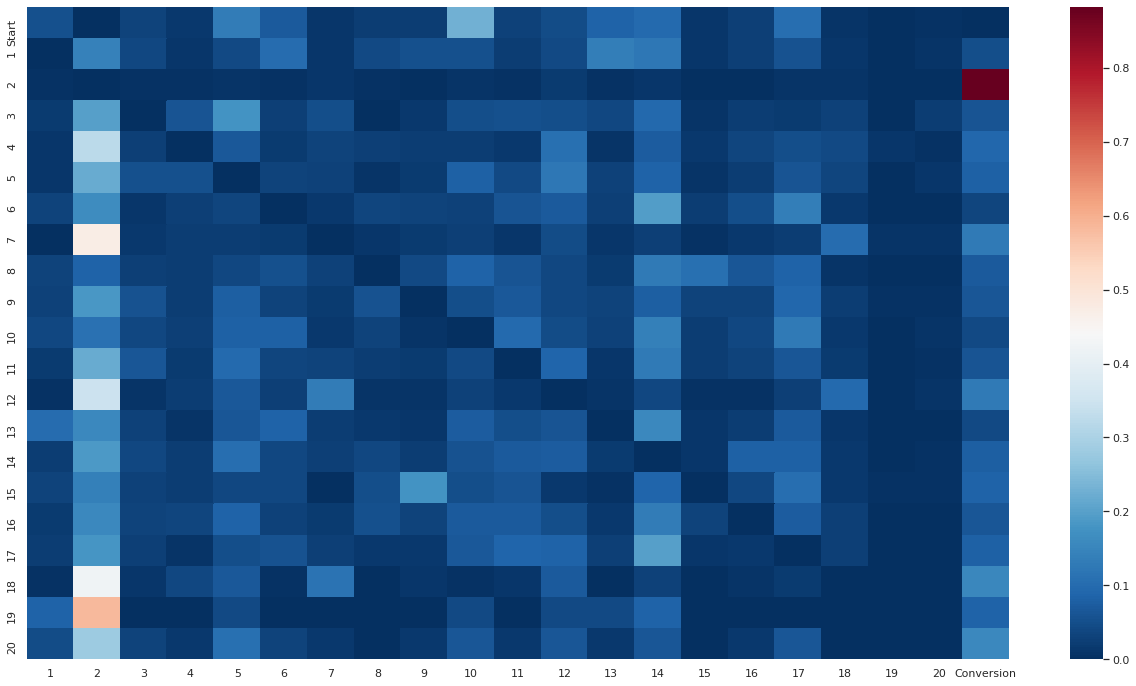

In [26]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(22, 12))
sns.heatmap(trans_matrix, cmap="RdBu_r")
plt.show()

### Conclusion: A Markov chain approach will look to model channel attribution by accounting for how a user journey data is structured.

### Analyzing the output of the Markov chain model gives us a “snapshot” of marketing channel effectiveness, at a specific point in time. We might be able to gain extra insights by looking at the model output for data just before and after a new marketing campaign launch, giving us essential information on how the campaign affected the performance of each channel.